# 셀 1 – 환경 설정 & 라이브러리

In [1]:
import os, random, json, pickle, time
import numpy as np
import pandas as pd
from tqdm import tqdm

# ---------- GPU 고정 (Stage‑1과 동일) ----------
os.environ["CUDA_DEVICE_ORDER"]    = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"     # 물리 GPU 3번

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Sampler
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_curve, auc
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Stage‑3 MIL init → device:", device)


Stage‑3 MIL init → device: cuda


# 셀 2 – 전역 하이퍼파라미터

In [2]:
import datetime
import os

# 실험별 고유 경로 생성
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_id = f"arcface_margin_0.4_{timestamp}"

CFG = {
    # 데이터 경로 (공유 읽기 전용)
    "bags_root"   : "/workspace/MIL/data/processed/bags",
    "tag"         : "arcface_margin_0.4",
    
    # 실험별 고유 출력 경로
    "experiment_id": experiment_id,
    "output_root" : f"/workspace/MIL/output/{experiment_id}",
    "model_dir"   : f"/workspace/MIL/output/{experiment_id}/models",
    "figure_dir"  : f"/workspace/MIL/output/{experiment_id}/figures", 
    "result_dir"  : f"/workspace/MIL/output/{experiment_id}/results",

    # Loader
    "batch_size"  : 64,          # 64 bags = pos32 + neg32 (GPU 효율성 향상)
    "num_workers" : 8,

    # 학습 (OneCycleLR 적용)
    "epochs"      : 40,
    "lr_start"    : 1e-5,        # 시작 학습률 (warm-up)
    "lr_max"      : 1e-4,        # 최대 학습률
    "lr_final"    : 1e-6,        # 최종 학습률
    "scheduler"   : "OneCycleLR", # 스케줄러 타입
    "warmup_pct"  : 0.1,         # 10% warm-up
    "weight_decay": 1e-4,
    "pos_weight"  : 1.0,         # 수정: Balanced Sampler와 함께 사용시 1.0
    "early_stop_patience": 4,    # 수정: 6→4 (15-20 epoch 안에 조기 종료)
    "early_stop_delta"   : 0.002,

    # 모델 구조
    "inst_dim"    : 256,         # ArcFace 임베딩 차원
    "win_len"     : 5,
    "block_len"   : 10,
    "attn_hidden" : 128,
}

# 출력 디렉토리 생성
for dir_path in [CFG["model_dir"], CFG["figure_dir"], CFG["result_dir"]]:
    os.makedirs(dir_path, exist_ok=True)
    
print(f"Experiment ID: {experiment_id}")
print(f"Output Root: {CFG['output_root']}")
print("=== OneCycleLR 설정 ===")
print(f"Warm-up: {CFG['lr_start']:.0e} → {CFG['lr_max']:.0e} ({CFG['warmup_pct']:.0%} epochs)")
print(f"Annealing: {CFG['lr_max']:.0e} → {CFG['lr_final']:.0e}")
print("=== Early Stopping 최적화 ===")
print(f"Patience: {CFG['early_stop_patience']} (15-20 epoch 안에 종료 예상)")
print(f"Delta: {CFG['early_stop_delta']}")
print(json.dumps({k:v for k,v in CFG.items() if not k.endswith('_dir')}, indent=2))

Experiment ID: arcface_margin_0.4_20250803_062739
Output Root: /workspace/MIL/output/arcface_margin_0.4_20250803_062739
=== OneCycleLR 설정 ===
Warm-up: 1e-05 → 1e-04 (10% epochs)
Annealing: 1e-04 → 1e-06
=== Early Stopping 최적화 ===
Patience: 4 (15-20 epoch 안에 종료 예상)
Delta: 0.002
{
  "bags_root": "/workspace/MIL/data/processed/bags",
  "tag": "arcface_margin_0.4",
  "experiment_id": "arcface_margin_0.4_20250803_062739",
  "output_root": "/workspace/MIL/output/arcface_margin_0.4_20250803_062739",
  "batch_size": 64,
  "num_workers": 8,
  "epochs": 40,
  "lr_start": 1e-05,
  "lr_max": 0.0001,
  "lr_final": 1e-06,
  "scheduler": "OneCycleLR",
  "warmup_pct": 0.1,
  "weight_decay": 0.0001,
  "pos_weight": 1.0,
  "early_stop_patience": 4,
  "early_stop_delta": 0.002,
  "inst_dim": 256,
  "win_len": 5,
  "block_len": 10,
  "attn_hidden": 128
}


# 셀 3 – Bag Dataset & Balanced Sampler

In [3]:
class BagDataset(Dataset):
    def __init__(self, split:str):
        pk_path = f"{CFG['bags_root']}/bags_{CFG['tag']}_{split}.pkl"
        with open(pk_path, "rb") as f:
            self.bags = pickle.load(f)
        print(f"[{split}] loaded {len(self.bags)}  bags")

    def __len__(self):
        return len(self.bags)

    def __getitem__(self, idx):
        bag = self.bags[idx]
        emb = torch.tensor(bag["bag_emb"], dtype=torch.float32)  # 명시적 float32
        label = torch.tensor([bag["bag_label"]], dtype=torch.float32)
        # 수정: "ratio" → "neg_ratio"로 변경
        ratio = bag.get("neg_ratio", 0.0)  # positive bag은 0.0
        return emb, label, ratio           # ratio로 난이도 분석

# Balanced batch: 1:1 (pos:neg) - BCE 기준 수정
class PosNegBatchSampler(Sampler):
    def __init__(self, labels, batch_size):
        # BCE에서 positive=1 (Multi Writer), negative=0 (Single Writer)
        self.pos_idx = [i for i,l in enumerate(labels) if l==1]  # Multi Writer
        self.neg_idx = [i for i,l in enumerate(labels) if l==0]  # Single Writer
        self.batch = batch_size
        self.half  = batch_size//2
        self.num_batches = min(len(self.pos_idx), len(self.neg_idx)) // self.half

    def __iter__(self):
        random.shuffle(self.pos_idx); random.shuffle(self.neg_idx)
        for b in range(self.num_batches):
            yield ( self.pos_idx[b*self.half:(b+1)*self.half]
                  + self.neg_idx[b*self.half:(b+1)*self.half] )

    def __len__(self):
        return self.num_batches

# 셀 4 – MIL 모델 (Standard Attention with Mean Pooling)

In [4]:
class AttentionMIL(nn.Module):
    """
    Standard Attention-based MIL with Mean Pooling
    Input: (B, block, win, D)
    1) win 차원 mean → (B, block, D)  
    2) Standard Attention → bag representation (hidden 공간에서 집계)
    """
    def __init__(self, inst_dim, hidden=128):
        super().__init__()
        self.proj = nn.Linear(inst_dim, hidden, bias=True)
        self.attn = nn.Sequential(
            nn.Tanh(),
            nn.Linear(hidden, 1, bias=False)
        )
        # Hidden 공간에서 classification (파라미터 효율성 + 안정성)
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x):                             # x:(B,block,win,D)
        B, blk, win, D = x.shape
        x = x.mean(dim=2)                             # (B,block,D) - Mean pooling

        h = self.proj(x)                              # (B,block,H) - Projected space
        a = self.attn(h).squeeze(-1)                  # (B,block) - Attention scores
        weights = torch.softmax(a, dim=1).unsqueeze(-1)  # (B,block,1)

        m = (h * weights).sum(dim=1)                  # (B,H) - Hidden 공간에서 집계
        logits = self.classifier(m).squeeze(-1)       # (B) - ReLU + Linear(H→1)
        return logits, weights.squeeze(-1)            # weights for analysis

# 셀 5 – 데이터로더 준비

In [5]:
train_set = BagDataset("train")
val_set   = BagDataset("val")
test_set  = BagDataset("test")

train_sampler = PosNegBatchSampler(
    [b["bag_label"] for b in train_set.bags], CFG["batch_size"]
)
val_sampler   = PosNegBatchSampler(
    [b["bag_label"] for b in val_set.bags],   CFG["batch_size"]
)

def collate_fn(batch):
    embs  = torch.stack([b[0] for b in batch])  # (B,block,win,D)
    labels= torch.stack([b[1] for b in batch]).squeeze(-1)
    ratios= torch.tensor([b[2] for b in batch])
    return embs, labels, ratios

# 완전 재현성을 위한 worker 초기화
def worker_init_fn(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

train_loader = DataLoader(
    train_set, batch_sampler=train_sampler,
    num_workers=CFG["num_workers"], pin_memory=True,
    collate_fn=collate_fn, worker_init_fn=worker_init_fn
)

# 학습 모니터링용: Balanced sampler (빠른 검증)
val_loader_balanced = DataLoader(
    val_set,   batch_sampler=val_sampler,
    num_workers=CFG["num_workers"], pin_memory=True,
    collate_fn=collate_fn, worker_init_fn=worker_init_fn
)

# Threshold 계산용: 자연 분포 (정확한 threshold)
val_loader_natural = DataLoader(
    val_set,  batch_size=CFG["batch_size"], shuffle=False,  # 자연 분포 유지
    num_workers=CFG["num_workers"], pin_memory=True,
    collate_fn=collate_fn, worker_init_fn=worker_init_fn
)

test_loader = DataLoader(
    test_set,  batch_size=CFG["batch_size"], shuffle=False,
    num_workers=CFG["num_workers"], pin_memory=True,
    collate_fn=collate_fn, worker_init_fn=worker_init_fn
)

print("데이터로더 설정 완료:")
print(f"- 학습용: Balanced sampler")
print(f"- 검증 (모니터링): Balanced sampler") 
print(f"- 검증 (Threshold): Natural distribution")
print(f"- 테스트: Natural distribution")

[train] loaded 12963  bags
[val] loaded 4320  bags
[test] loaded 4320  bags
데이터로더 설정 완료:
- 학습용: Balanced sampler
- 검증 (모니터링): Balanced sampler
- 검증 (Threshold): Natural distribution
- 테스트: Natural distribution


# 셀 6 – 모델/옵티마이저/손실

In [6]:
model = AttentionMIL(CFG["inst_dim"], hidden=CFG["attn_hidden"]).to(device)

pos_w = torch.tensor([CFG["pos_weight"]], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_w)

# 초기 학습률 낮춤 (OneCycleLR이 자동으로 warm-up 처리)
optimizer = optim.AdamW(model.parameters(),
                        lr=1e-5, weight_decay=CFG["weight_decay"])  # 시작 lr 낮춤

# OneCycleLR: Warm-up + Cosine Annealing (더 안정적)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4,           # 최대 학습률
    epochs=CFG["epochs"],
    steps_per_epoch=len(train_loader),
    pct_start=0.1,         # 10% warm-up (40 epochs → 4 epochs warm-up)
    div_factor=10,         # 시작 lr = max_lr/10 = 1e-5
    final_div_factor=100   # 최종 lr = max_lr/100 = 1e-6
)

print("=== 학습 스케줄 ===")
print(f"시작 lr: {1e-4/10:.0e} (warm-up)")
print(f"최대 lr: {1e-4:.0e} (epoch {CFG['epochs']*0.1:.0f} 도달)")
print(f"최종 lr: {1e-4/100:.0e} (annealing)")
print(f"Warm-up epochs: {CFG['epochs']*0.1:.0f}")
print(model)

=== 학습 스케줄 ===
시작 lr: 1e-05 (warm-up)
최대 lr: 1e-04 (epoch 4 도달)
최종 lr: 1e-06 (annealing)
Warm-up epochs: 4
AttentionMIL(
  (proj): Linear(in_features=256, out_features=128, bias=True)
  (attn): Sequential(
    (0): Tanh()
    (1): Linear(in_features=128, out_features=1, bias=False)
  )
  (classifier): Sequential(
    (0): ReLU()
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
)


# 셀 7 – 학습 / 평가 헬퍼

In [7]:
def sigmoid(x): return 1/(1+np.exp(-x))

def run_epoch(loader, train=True):
    preds, targs, ratios = [], [], []
    running_loss = 0
    if train: model.train()
    else:     model.eval()

    for x, y, r in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(train):
            logit,_ = model(x)
            loss = criterion(logit, y)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()  # OneCycleLR: 배치마다 step
        running_loss += loss.item()*len(y)

        preds.extend( sigmoid(logit.detach().cpu().numpy()) )
        targs.extend( y.cpu().numpy() )
        ratios.extend( r.numpy() )

    loss = running_loss/len(targs)
    return np.array(preds), np.array(targs), np.array(ratios), loss

def calc_metrics(y_true, y_prob, thr=0.5):
    y_pred = (y_prob>=thr).astype(int)
    acc   = accuracy_score(y_true, y_pred)
    p,r,f,_ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label=1, zero_division=0)
    fpr,tpr,thr_ = roc_curve(y_true, y_prob)
    auc_val = auc(fpr,tpr)
    return {"ACC":acc,"PREC":p,"REC":r,"F1":f,"AUC":auc_val}, (fpr,tpr,thr_)

# 셀 8 – 학습 루프 (Early‑Stopping on F1)

In [8]:
best_f1, patience = 0, 0
best_thr_saved = 0.5  # Best F1과 함께 저장할 threshold
history = []

for epoch in range(1, CFG["epochs"]+1):
    print(f"\nEpoch {epoch}/{CFG['epochs']}")
    # 현재 학습률 출력 (OneCycleLR 모니터링)
    current_lr = scheduler.get_last_lr()[0]
    print(f"Current LR: {current_lr:.2e}")
    
    tr_p, tr_y, _, tr_loss = run_epoch(train_loader, train=True)
    
    # 1. 빠른 모니터링: Balanced validation (F1 계산용)
    vl_p_bal, vl_y_bal, vl_r_bal, vl_loss = run_epoch(val_loader_balanced, train=False)
    fpr_bal, tpr_bal, thr_bal = roc_curve(vl_y_bal, vl_p_bal)
    gmean_bal = np.sqrt(tpr_bal*(1-fpr_bal))
    thr_balanced = thr_bal[np.argmax(gmean_bal)]
    metr_bal, _ = calc_metrics(vl_y_bal, vl_p_bal, thr_balanced)
    
    # 2. 정확한 Threshold: Natural distribution validation
    vl_p_nat, vl_y_nat, vl_r_nat, _ = run_epoch(val_loader_natural, train=False)
    fpr_nat, tpr_nat, thr_nat = roc_curve(vl_y_nat, vl_p_nat)
    gmean_nat = np.sqrt(tpr_nat*(1-fpr_nat))
    best_thr = thr_nat[np.argmax(gmean_nat)]  # 자연 분포에서 계산
    
    # 기록용 메트릭 (Balanced F1 + Natural Threshold)
    metr = {
        "F1": metr_bal["F1"],      # Balanced에서 F1 (모니터링용)
        "PREC": metr_bal["PREC"],
        "REC": metr_bal["REC"],
        "AUC": metr_bal["AUC"],
        "THR": best_thr,           # Natural에서 threshold
        "LR": current_lr           # 학습률 기록
    }
    
    print(f"Val (Bal) F1={metr['F1']:.3f}  Recall={metr['REC']:.3f}  AUC={metr['AUC']:.3f}")
    print(f"    (Nat) thr={best_thr:.3f}  [자연분포 threshold]")

    history.append(metr)
    # OneCycleLR은 배치마다 step하므로 여기서 추가 step 불필요

    # Early‑Stopping: Balanced F1 기준, Natural threshold 저장
    if metr["F1"] > best_f1 + CFG["early_stop_delta"]:
        best_f1 = metr["F1"]; patience = 0
        best_thr_saved = best_thr  # Natural distribution threshold 저장
        model_path = f"{CFG['model_dir']}/mil_best.pth"
        torch.save(model.state_dict(), model_path)
        print(f"  ▲  Best model saved (F1={best_f1:.3f}, thr={best_thr_saved:.3f})")
    else:
        patience += 1
        print(f"  patience {patience}/{CFG['early_stop_patience']}")
        if patience >= CFG["early_stop_patience"]:
            print("Early stop triggered"); break

# 저장된 best threshold 사용 (Natural distribution 기준)
best_thr = best_thr_saved
print(f"\nUsing saved best threshold (natural dist): {best_thr:.4f}")


Epoch 1/40
Current LR: 1.00e-05


Val (Bal) F1=0.578  Recall=0.633  AUC=0.540
    (Nat) thr=0.482  [자연분포 threshold]
  ▲  Best model saved (F1=0.578, thr=0.482)

Epoch 2/40
Current LR: 2.32e-05


Val (Bal) F1=0.529  Recall=0.505  AUC=0.569
    (Nat) thr=0.487  [자연분포 threshold]
  patience 1/4

Epoch 3/40
Current LR: 5.51e-05


Val (Bal) F1=0.601  Recall=0.617  AUC=0.612
    (Nat) thr=0.492  [자연분포 threshold]
  ▲  Best model saved (F1=0.601, thr=0.492)

Epoch 4/40
Current LR: 8.70e-05


Val (Bal) F1=0.619  Recall=0.636  AUC=0.630
    (Nat) thr=0.495  [자연분포 threshold]
  ▲  Best model saved (F1=0.619, thr=0.495)

Epoch 5/40
Current LR: 1.00e-04


Val (Bal) F1=0.660  Recall=0.717  AUC=0.652
    (Nat) thr=0.497  [자연분포 threshold]
  ▲  Best model saved (F1=0.660, thr=0.497)

Epoch 6/40
Current LR: 9.98e-05


Val (Bal) F1=0.626  Recall=0.648  AUC=0.644
    (Nat) thr=0.502  [자연분포 threshold]
  patience 1/4

Epoch 7/40
Current LR: 9.92e-05


Val (Bal) F1=0.619  Recall=0.618  AUC=0.660
    (Nat) thr=0.511  [자연분포 threshold]
  patience 2/4

Epoch 8/40
Current LR: 9.83e-05


Val (Bal) F1=0.634  Recall=0.676  AUC=0.647
    (Nat) thr=0.528  [자연분포 threshold]
  patience 3/4

Epoch 9/40
Current LR: 9.70e-05


Val (Bal) F1=0.638  Recall=0.666  AUC=0.643
    (Nat) thr=0.551  [자연분포 threshold]
  patience 4/4
Early stop triggered

Using saved best threshold (natural dist): 0.4972


# 셀 9 – 난이도(비율)별 성능 평가

In [9]:
def ratio_eval(loader, thr):
    pred_all, true_all, ratio_all = [], [], []
    for x,y,r in loader:
        x = x.to(device)
        with torch.no_grad():
            p,_ = model(x)
        pred_all.extend( sigmoid(p.cpu().numpy()) )
        true_all.extend( y.numpy() )
        ratio_all.extend( r.numpy() )
    pred_all, true_all, ratio_all = map(np.array,[pred_all,true_all,ratio_all])

    for ratio in [0,0.05,0.10,0.20,0.30]:
        idx = ratio_all==ratio
        if idx.sum()==0: continue
        m,_ = calc_metrics(true_all[idx], pred_all[idx], thr)
        print(f"ratio={ratio:>4}: F1={m['F1']:.3f}  Rec={m['REC']:.3f}  N={idx.sum()}")

# 훈련 완료 후 best model 로드
model_path = f"{CFG['model_dir']}/mil_best.pth"
model.load_state_dict(torch.load(model_path))
print(f"✅ Best model loaded from: {model_path}")

print("\n=== Difficulty‑wise validation (Natural dist) ===")
ratio_eval(val_loader_natural, thr=best_thr)

✅ Best model loaded from: /workspace/MIL/output/arcface_margin_0.4_20250803_062739/models/mil_best.pth

=== Difficulty‑wise validation (Natural dist) ===


/tmp/ipykernel_2091/1769276164.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


ratio=   0: F1=0.000  Rec=0.000  N=1440
ratio=0.05: F1=0.776  Rec=0.633  N=720
ratio= 0.1: F1=0.781  Rec=0.640  N=720
ratio= 0.2: F1=0.873  Rec=0.775  N=720
ratio= 0.3: F1=0.946  Rec=0.897  N=720


/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


# 셀 10 – Test 셋 최종 보고

In [10]:
model_path = f"{CFG['model_dir']}/mil_best.pth"
model.load_state_dict(torch.load(model_path))
ts_p, ts_y, ts_r, _ = run_epoch(test_loader, train=False)

test_m, _ = calc_metrics(ts_y, ts_p, best_thr)
print(f"\nTEST  F1={test_m['F1']:.3f}  Recall={test_m['REC']:.3f}  AUC={test_m['AUC']:.3f}")

print("\n--- Test difficulty ---")
ratio_eval(test_loader, thr=best_thr)

/tmp/ipykernel_2091/699088825.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
                                             


TEST  F1=0.756  Recall=0.807  AUC=0.635

--- Test difficulty ---


ratio=   0: F1=0.000  Rec=0.000  N=1440
ratio=0.05: F1=0.838  Rec=0.721  N=720
ratio= 0.1: F1=0.861  Rec=0.756  N=720
ratio= 0.2: F1=0.903  Rec=0.824  N=720
ratio= 0.3: F1=0.963  Rec=0.928  N=720


/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


# 셀 11 - 학습 곡선 시각화

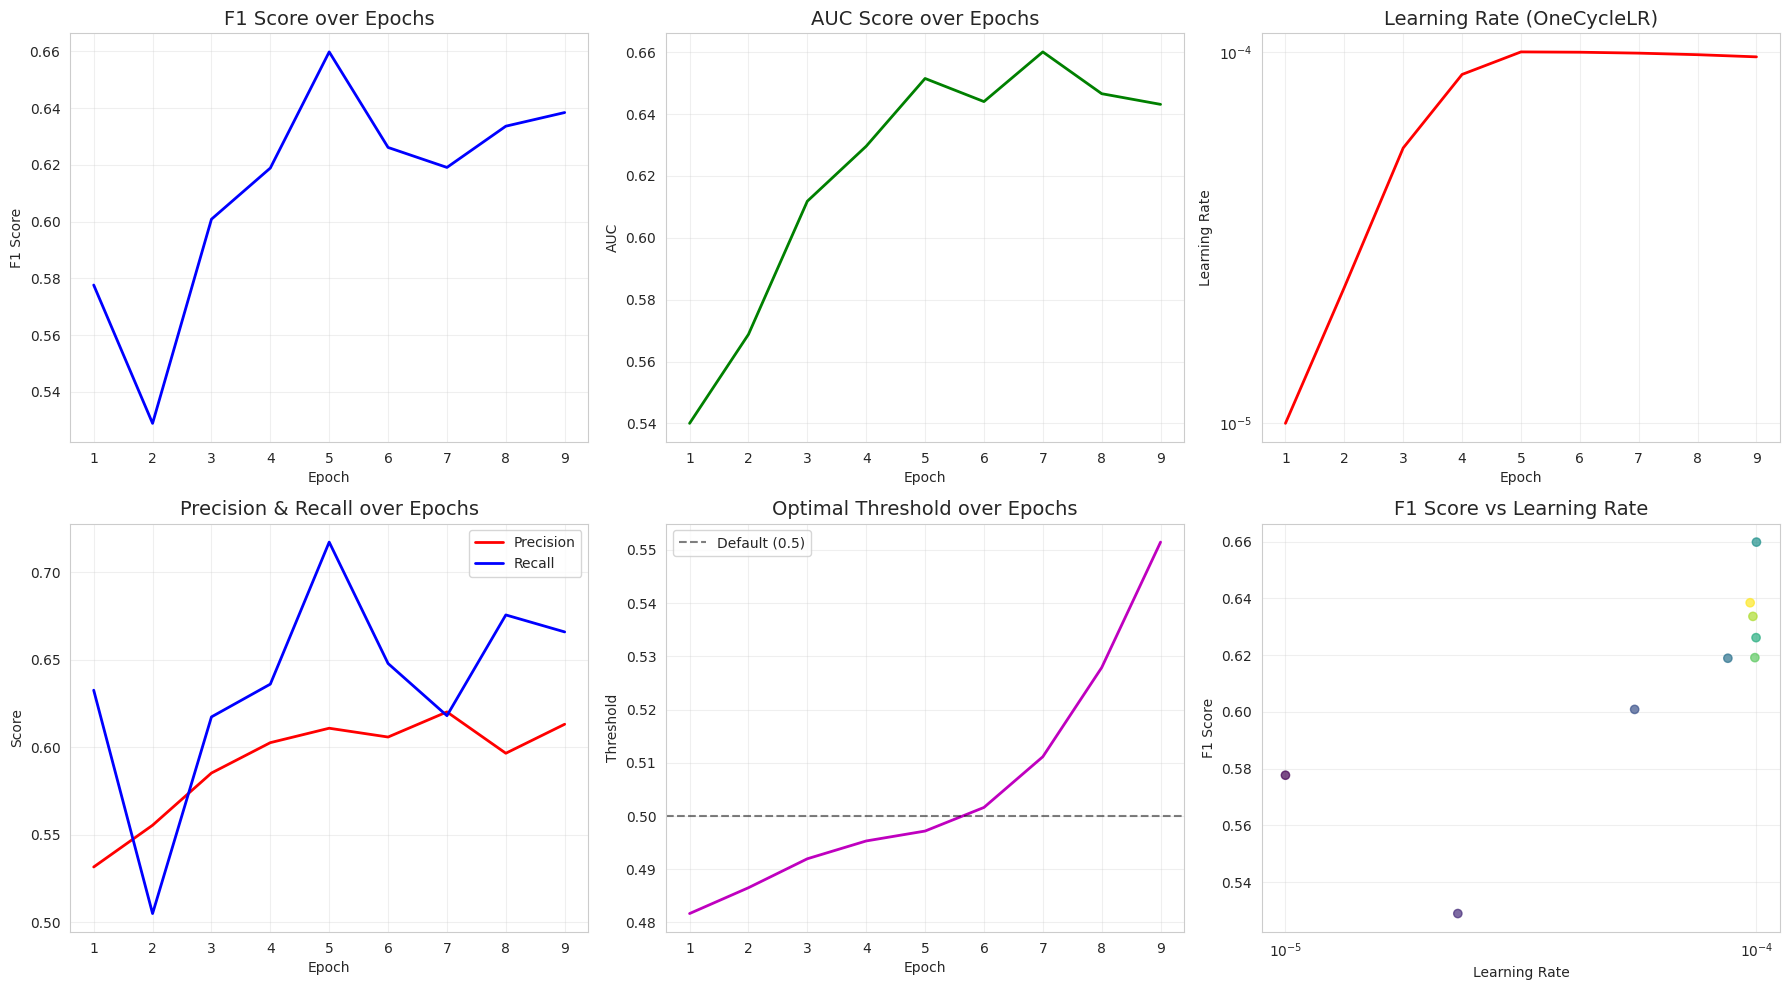

Best F1 Score: 0.6599
Final Threshold: 0.4972
OneCycleLR: Warm-up → Peak → Annealing
Figure saved: /workspace/MIL/output/arcface_margin_0.4_20250803_062739/figures/training_curves.png


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# 학습 곡선 시각화 (OneCycleLR 포함)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

epochs = range(1, len(history)+1)

# 1. F1 Score 추이
axes[0,0].plot(epochs, [h['F1'] for h in history], 'b-', linewidth=2)
axes[0,0].set_title('F1 Score over Epochs', fontsize=14)
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('F1 Score')
axes[0,0].grid(True, alpha=0.3)

# 2. AUC 추이
axes[0,1].plot(epochs, [h['AUC'] for h in history], 'g-', linewidth=2)
axes[0,1].set_title('AUC Score over Epochs', fontsize=14)
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('AUC')
axes[0,1].grid(True, alpha=0.3)

# 3. Learning Rate 추이 (OneCycleLR)
axes[0,2].plot(epochs, [h['LR'] for h in history], 'r-', linewidth=2)
axes[0,2].set_title('Learning Rate (OneCycleLR)', fontsize=14)
axes[0,2].set_xlabel('Epoch')
axes[0,2].set_ylabel('Learning Rate')
axes[0,2].set_yscale('log')  # Log scale로 변화 명확하게
axes[0,2].grid(True, alpha=0.3)

# 4. Precision & Recall 추이
axes[1,0].plot(epochs, [h['PREC'] for h in history], 'r-', label='Precision', linewidth=2)
axes[1,0].plot(epochs, [h['REC'] for h in history], 'b-', label='Recall', linewidth=2)
axes[1,0].set_title('Precision & Recall over Epochs', fontsize=14)
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Score')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Threshold 추이
axes[1,1].plot(epochs, [h['THR'] for h in history], 'm-', linewidth=2)
axes[1,1].set_title('Optimal Threshold over Epochs', fontsize=14)
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Threshold')
axes[1,1].axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='Default (0.5)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. F1 vs Learning Rate (상관관계)
axes[1,2].scatter([h['LR'] for h in history], [h['F1'] for h in history], 
                  c=range(len(history)), cmap='viridis', alpha=0.7)
axes[1,2].set_title('F1 Score vs Learning Rate', fontsize=14)
axes[1,2].set_xlabel('Learning Rate')
axes[1,2].set_ylabel('F1 Score')
axes[1,2].set_xscale('log')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
fig_path = f"{CFG['figure_dir']}/training_curves.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Best F1 Score: {best_f1:.4f}")
print(f"Final Threshold: {best_thr:.4f}")
print(f"OneCycleLR: Warm-up → Peak → Annealing")
print(f"Figure saved: {fig_path}")

# 셀 12 - ROC Curve 및 혼동 행렬

/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


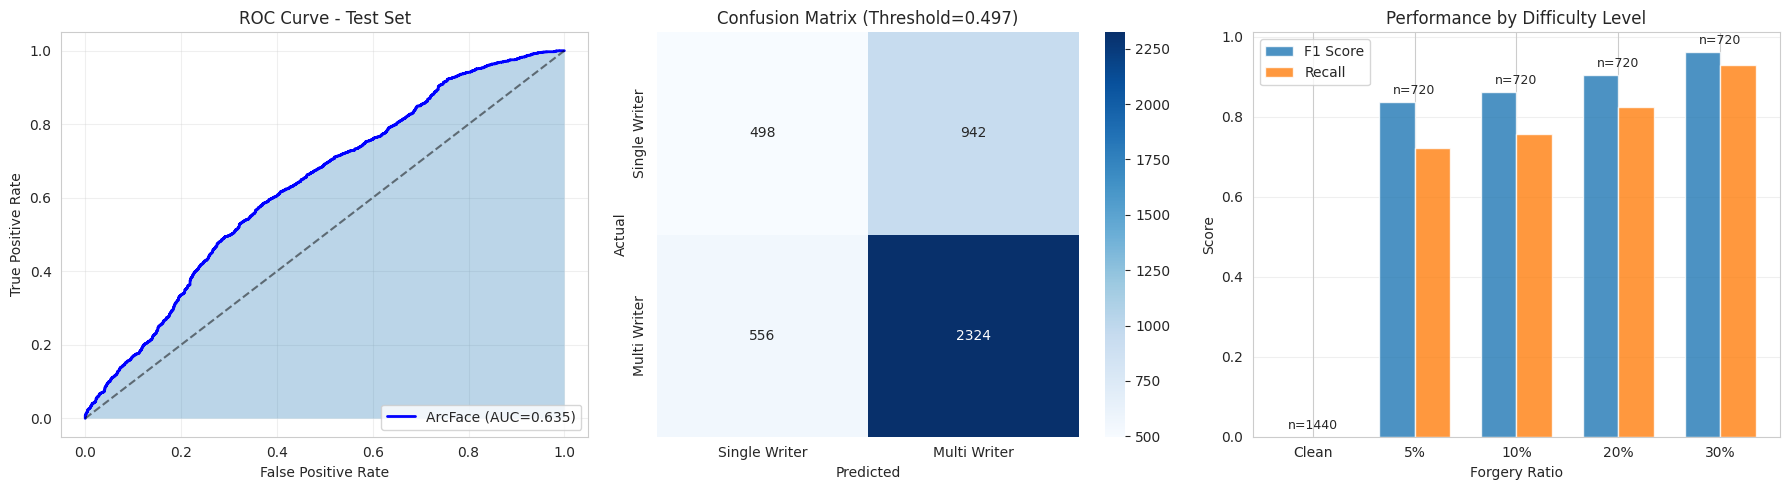


=== Detailed Test Results ===
Test Accuracy: 0.6532
Test Precision: 0.7116
Test Recall: 0.8069
Test F1: 0.7563
Test AUC: 0.6354
Figure saved: /workspace/MIL/output/arcface_margin_0.4_20250803_062739/figures/test_results.png


In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ROC Curve 및 혼동 행렬 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. ROC Curve
fpr_test, tpr_test, _ = roc_curve(ts_y, ts_p)
axes[0].plot(fpr_test, tpr_test, 'b-', linewidth=2, label=f'ArcFace (AUC={test_m["AUC"]:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].fill_between(fpr_test, tpr_test, alpha=0.3)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Test Set')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# 2. Confusion Matrix
ts_pred = (ts_p >= best_thr).astype(int)
cm = confusion_matrix(ts_y, ts_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], 
            xticklabels=['Single Writer', 'Multi Writer'],
            yticklabels=['Single Writer', 'Multi Writer'])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'Confusion Matrix (Threshold={best_thr:.3f})')

# 3. Difficulty-wise Performance Bar Chart
ratios = [0.0, 0.05, 0.10, 0.20, 0.30]
f1_scores = []
recalls = []
counts = []

for ratio in ratios:
    idx = ts_r == ratio
    if idx.sum() == 0:
        f1_scores.append(0)
        recalls.append(0)
        counts.append(0)
    else:
        m, _ = calc_metrics(ts_y[idx], ts_p[idx], best_thr)
        f1_scores.append(m['F1'])
        recalls.append(m['REC'])
        counts.append(idx.sum())

x = np.arange(len(ratios))
width = 0.35

axes[2].bar(x - width/2, f1_scores, width, label='F1 Score', alpha=0.8)
axes[2].bar(x + width/2, recalls, width, label='Recall', alpha=0.8)

# Add count labels on top
for i, (f1, rec, cnt) in enumerate(zip(f1_scores, recalls, counts)):
    axes[2].text(i, max(f1, rec) + 0.02, f'n={cnt}', ha='center', fontsize=9)

axes[2].set_xlabel('Forgery Ratio')
axes[2].set_ylabel('Score')
axes[2].set_title('Performance by Difficulty Level')
axes[2].set_xticks(x)
axes[2].set_xticklabels([f'{r:.0%}' if r > 0 else 'Clean' for r in ratios])
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
fig_path = f"{CFG['figure_dir']}/test_results.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

# Print detailed test results
print("\n=== Detailed Test Results ===")
print(f"Test Accuracy: {test_m['ACC']:.4f}")
print(f"Test Precision: {test_m['PREC']:.4f}")
print(f"Test Recall: {test_m['REC']:.4f}")
print(f"Test F1: {test_m['F1']:.4f}")
print(f"Test AUC: {test_m['AUC']:.4f}")
print(f"Figure saved: {fig_path}")

# 셀 13 - Attention Weight Analysis

Analyzing attention weights on test data...


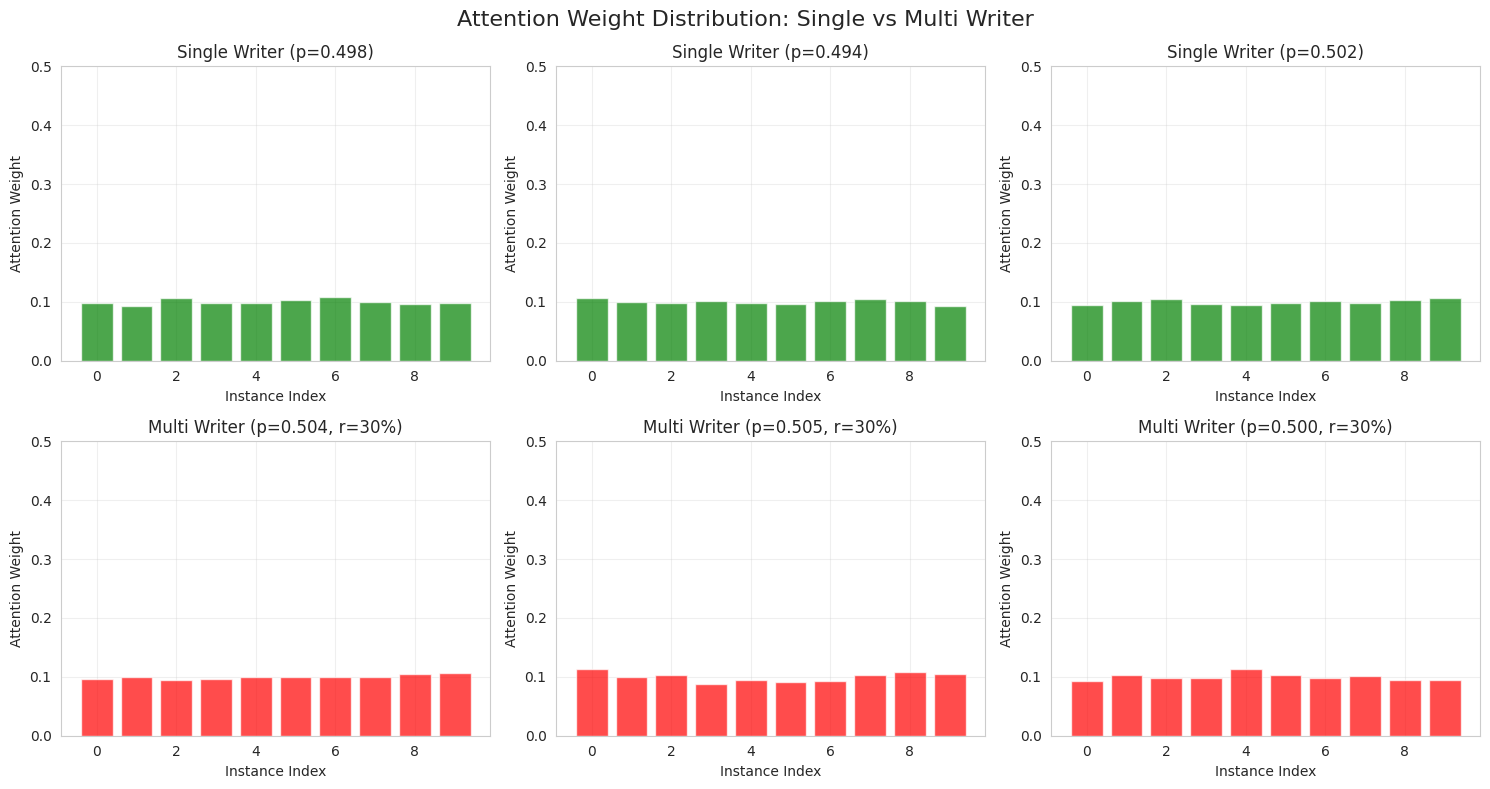

Attention analysis saved: /workspace/MIL/output/arcface_margin_0.4_20250803_062739/figures/attention_analysis.png


In [13]:
# Attention Weight 분석 및 시각화
def analyze_attention_weights(model, loader, num_samples=6):
    model.eval()
    
    pos_samples = []
    neg_samples = []
    
    with torch.no_grad():
        for x, y, r in loader:
            x = x.to(device)
            logits, attn_weights = model(x)
            probs = sigmoid(logits.cpu().numpy())
            
            # Positive bags (single writer)
            pos_idx = (y == 0).nonzero(as_tuple=True)[0]
            for idx in pos_idx[:num_samples//2]:
                if len(pos_samples) < num_samples//2:
                    pos_samples.append({
                        'attention': attn_weights[idx].cpu().numpy(),
                        'prob': probs[idx],
                        'ratio': r[idx].item()
                    })
            
            # Negative bags (multi writer)
            neg_idx = (y == 1).nonzero(as_tuple=True)[0]
            for idx in neg_idx[:num_samples//2]:
                if len(neg_samples) < num_samples//2:
                    neg_samples.append({
                        'attention': attn_weights[idx].cpu().numpy(),
                        'prob': probs[idx],
                        'ratio': r[idx].item()
                    })
            
            if len(pos_samples) >= num_samples//2 and len(neg_samples) >= num_samples//2:
                break
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # Plot positive samples (top row)
    for i, sample in enumerate(pos_samples):
        ax = axes[0, i]
        ax.bar(range(len(sample['attention'])), sample['attention'], color='green', alpha=0.7)
        ax.set_ylim(0, 0.5)
        ax.set_xlabel('Instance Index')
        ax.set_ylabel('Attention Weight')
        ax.set_title(f'Single Writer (p={sample["prob"]:.3f})')
        ax.grid(True, alpha=0.3)
    
    # Plot negative samples (bottom row)
    for i, sample in enumerate(neg_samples):
        ax = axes[1, i]
        ax.bar(range(len(sample['attention'])), sample['attention'], color='red', alpha=0.7)
        ax.set_ylim(0, 0.5)
        ax.set_xlabel('Instance Index')
        ax.set_ylabel('Attention Weight')
        ax.set_title(f'Multi Writer (p={sample["prob"]:.3f}, r={sample["ratio"]:.0%})')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Attention Weight Distribution: Single vs Multi Writer', fontsize=16)
    plt.tight_layout()
    fig_path = f"{CFG['figure_dir']}/attention_analysis.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Attention analysis saved: {fig_path}")

# Run attention analysis
print("Analyzing attention weights on test data...")
analyze_attention_weights(model, test_loader, num_samples=6)

# 셀 14 - Save Results to JSON

In [14]:
import json
import datetime
import numpy as np

# JSON 직렬화를 위한 헬퍼 함수
def convert_to_serializable(obj):
    """numpy/torch 타입을 Python 기본 타입으로 변환"""
    if isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

# Save comprehensive results
result_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Prepare results dictionary
results = {
    "experiment": "AB_MIL_ArcFace_256d",
    "experiment_id": CFG["experiment_id"],
    "timestamp": result_timestamp,
    "config": CFG,
    "validation_strategy": {
        "early_stopping": "Balanced F1 (빠른 모니터링)",
        "threshold_calc": "Natural distribution (편향 방지)",
        "description": "이중 검증으로 분포 편향 문제 해결"
    },
    "optimizer_strategy": {
        "optimizer": "AdamW",
        "scheduler": "OneCycleLR",
        "warmup_epochs": CFG["epochs"] * CFG["warmup_pct"],
        "description": "Warm-up으로 초기 학습 안정성 확보"
    },
    "best_threshold": float(best_thr),
    "best_f1_val": float(best_f1),
    "epochs_trained": len(history),
    "test_metrics": {k: float(v) for k, v in test_m.items()},
    "history": convert_to_serializable(history),  # 타입 변환 적용
    "difficulty_performance": {}
}

# Add difficulty-wise performance
for ratio in [0.0, 0.05, 0.10, 0.20, 0.30]:
    idx = ts_r == ratio
    if idx.sum() > 0:
        m, _ = calc_metrics(ts_y[idx], ts_p[idx], best_thr)
        results["difficulty_performance"][f"ratio_{ratio}"] = {
            "count": int(idx.sum()),
            "f1": float(m['F1']),
            "recall": float(m['REC']),
            "precision": float(m['PREC']),
            "accuracy": float(m['ACC'])
        }

# 전체 결과를 JSON 직렬화 가능하게 변환
results = convert_to_serializable(results)

# Save to JSON
output_path = f"{CFG['result_dir']}/experiment_results.json"
with open(output_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n=== Results saved to: {output_path} ===")

# Also save a summary report
report = f"""
ArcFace MIL Experiment Report
=============================
Experiment ID: {CFG["experiment_id"]}
Timestamp: {result_timestamp}
Model: AB_MIL with ArcFace embeddings (256d)

Optimization Strategy (학습 안정성 향상):
- Optimizer: AdamW (weight_decay={CFG['weight_decay']})
- Scheduler: OneCycleLR
  - Warm-up: {CFG['lr_start']:.0e} → {CFG['lr_max']:.0e} ({CFG['warmup_pct']:.0%} epochs)
  - Annealing: {CFG['lr_max']:.0e} → {CFG['lr_final']:.0e}
- 목적: 초기 gradient 폭발 방지, 안정적 수렴

Validation Strategy (분포 편향 방지):
- Early Stopping: Balanced F1 (빠른 학습 모니터링)
- Threshold Calc: Natural distribution (정확한 threshold)
- 목적: 균형잡힌 validation이 실제 test 성능에 미치는 편향 제거

Configuration:
- Batch size: {CFG['batch_size']}
- Learning rate: {CFG['lr_start']:.0e} → {CFG['lr_max']:.0e} → {CFG['lr_final']:.0e}
- Positive weight: {CFG['pos_weight']}
- Epochs trained: {len(history)}

Best Validation Performance:
- F1 Score (Balanced): {best_f1:.4f}
- Optimal Threshold (Natural): {best_thr:.4f}

Test Set Performance:
- Accuracy: {test_m['ACC']:.4f}
- Precision: {test_m['PREC']:.4f}
- Recall: {test_m['REC']:.4f}
- F1 Score: {test_m['F1']:.4f}
- AUC: {test_m['AUC']:.4f}

Performance by Difficulty:
"""

for ratio, perf in results["difficulty_performance"].items():
    report += f"\n{ratio}: F1={perf['f1']:.3f}, Recall={perf['recall']:.3f} (n={perf['count']})"

report_path = f"{CFG['result_dir']}/experiment_report.txt"
with open(report_path, 'w') as f:
    f.write(report)

print(f"Report saved to: {report_path}")

# Display summary
print("\n" + "="*70)
print("EXPERIMENT COMPLETE - OneCycleLR + 분포 편향 방지 적용")
print("="*70)
print(f"Experiment ID: {CFG['experiment_id']}")
print(f"Scheduler: OneCycleLR (Warm-up → Peak → Annealing)")
print(f"Validation: Balanced F1 + Natural Threshold")
print(f"Best F1 Score (Balanced): {best_f1:.4f}")
print(f"Test F1 Score: {test_m['F1']:.4f}")
print(f"Test AUC: {test_m['AUC']:.4f}")
print(f"Optimal Threshold (Natural): {best_thr:.4f}")
print(f"Output Directory: {CFG['output_root']}")
print("="*70)


=== Results saved to: /workspace/MIL/output/arcface_margin_0.4_20250803_062739/results/experiment_results.json ===
Report saved to: /workspace/MIL/output/arcface_margin_0.4_20250803_062739/results/experiment_report.txt

EXPERIMENT COMPLETE - OneCycleLR + 분포 편향 방지 적용
Experiment ID: arcface_margin_0.4_20250803_062739
Scheduler: OneCycleLR (Warm-up → Peak → Annealing)
Validation: Balanced F1 + Natural Threshold
Best F1 Score (Balanced): 0.6599
Test F1 Score: 0.7563
Test AUC: 0.6354
Optimal Threshold (Natural): 0.4972
Output Directory: /workspace/MIL/output/arcface_margin_0.4_20250803_062739


/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


# 셀 15 - Threshold Analysis

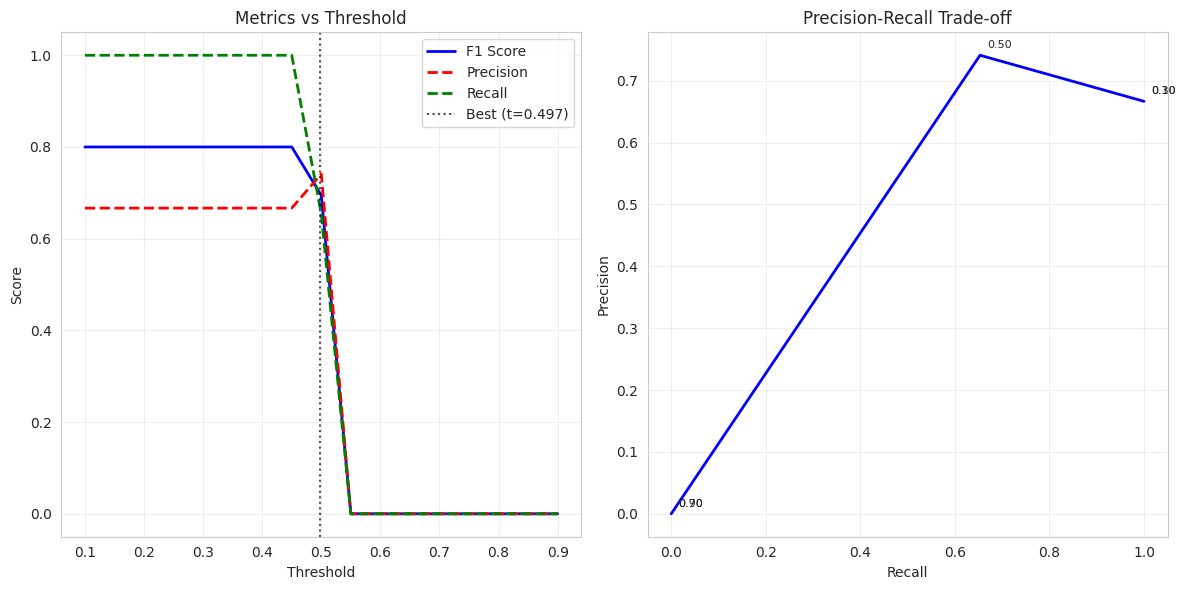


=== Threshold Recommendations ===
For 95% Recall: threshold=0.100, F1=0.800, Precision=0.667
For 90% Recall: threshold=0.100, F1=0.800, Precision=0.667
For 85% Recall: threshold=0.100, F1=0.800, Precision=0.667

Threshold analysis saved: /workspace/MIL/output/arcface_margin_0.4_20250803_062739/figures/threshold_analysis.png


In [15]:
# Threshold sensitivity analysis
thresholds = np.linspace(0.1, 0.9, 17)
metrics_by_threshold = {
    'f1': [], 'precision': [], 'recall': [], 'accuracy': []
}

for thr in thresholds:
    m, _ = calc_metrics(ts_y, ts_p, thr)
    metrics_by_threshold['f1'].append(m['F1'])
    metrics_by_threshold['precision'].append(m['PREC'])
    metrics_by_threshold['recall'].append(m['REC'])
    metrics_by_threshold['accuracy'].append(m['ACC'])

# Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(thresholds, metrics_by_threshold['f1'], 'b-', linewidth=2, label='F1 Score')
plt.plot(thresholds, metrics_by_threshold['precision'], 'r--', linewidth=2, label='Precision')
plt.plot(thresholds, metrics_by_threshold['recall'], 'g--', linewidth=2, label='Recall')
plt.axvline(x=best_thr, color='k', linestyle=':', alpha=0.7, label=f'Best (t={best_thr:.3f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Trade-off visualization
plt.plot(metrics_by_threshold['recall'], metrics_by_threshold['precision'], 'b-', linewidth=2)
for i, thr in enumerate(thresholds[::4]):  # Show every 4th threshold
    plt.annotate(f'{thr:.2f}', 
                 (metrics_by_threshold['recall'][i*4], metrics_by_threshold['precision'][i*4]),
                 textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Trade-off')
plt.grid(True, alpha=0.3)

plt.tight_layout()
fig_path = f"{CFG['figure_dir']}/threshold_analysis.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

# Find thresholds for specific targets
print("\n=== Threshold Recommendations ===")
for target_recall in [0.95, 0.90, 0.85]:
    idx = np.argmin(np.abs(np.array(metrics_by_threshold['recall']) - target_recall))
    print(f"For {target_recall:.0%} Recall: threshold={thresholds[idx]:.3f}, "
          f"F1={metrics_by_threshold['f1'][idx]:.3f}, "
          f"Precision={metrics_by_threshold['precision'][idx]:.3f}")

print(f"\nThreshold analysis saved: {fig_path}")

In [16]:
# 셀 16 - 라벨 정합성 검증

print("\n" + "="*70)
print("라벨 정합성 검증 - bag_label ↔ neg_ratio")
print("="*70)

def verify_label_consistency(bags, split_name):
    """
    라벨 정합성 검증 함수
    - bag_label=0 (single writer) → neg_ratio=0.0 이어야 함
    - bag_label=1 (multi writer) → neg_ratio>0 이어야 함
    """
    print(f"\n[{split_name.upper()}] 검증 중...")
    
    # 전체 bag 수
    total_bags = len(bags)
    print(f"전체 Bag 수: {total_bags}")
    
    # bag_label=0인 경우 검증 (Single Writer)
    single_writer_bags = [b for b in bags if b["bag_label"] == 0]
    single_writer_correct = all(b.get("neg_ratio", 0.0) == 0.0 for b in single_writer_bags)
    single_writer_errors = [b for b in single_writer_bags if b.get("neg_ratio", 0.0) != 0.0]
    
    print(f"\nSingle Writer (bag_label=0) 검증:")
    print(f"  - 총 개수: {len(single_writer_bags)}")
    print(f"  - neg_ratio=0.0 조건 만족: {single_writer_correct}")
    if not single_writer_correct:
        print(f"  - ❌ 오류 발견! {len(single_writer_errors)}개 bag에서 neg_ratio != 0.0")
        for i, err_bag in enumerate(single_writer_errors[:5]):  # 처음 5개만 출력
            print(f"    예시 {i+1}: neg_ratio={err_bag.get('neg_ratio', 'None')}")
    else:
        print(f"  - ✅ 모든 Single Writer bag이 올바름 (neg_ratio=0.0)")
    
    # bag_label=1인 경우 검증 (Multi Writer)
    multi_writer_bags = [b for b in bags if b["bag_label"] == 1]
    multi_writer_correct = all(b.get("neg_ratio", 0.0) > 0.0 for b in multi_writer_bags)
    multi_writer_errors = [b for b in multi_writer_bags if b.get("neg_ratio", 0.0) == 0.0]
    
    print(f"\nMulti Writer (bag_label=1) 검증:")
    print(f"  - 총 개수: {len(multi_writer_bags)}")
    print(f"  - neg_ratio>0 조건 만족: {multi_writer_correct}")
    if not multi_writer_correct:
        print(f"  - ❌ 오류 발견! {len(multi_writer_errors)}개 bag에서 neg_ratio = 0.0")
        for i, err_bag in enumerate(multi_writer_errors[:5]):  # 처음 5개만 출력
            print(f"    예시 {i+1}: neg_ratio={err_bag.get('neg_ratio', 'None')}")
    else:
        print(f"  - ✅ 모든 Multi Writer bag이 올바름 (neg_ratio>0)")
    
    # neg_ratio 분포 출력
    if multi_writer_bags:
        neg_ratios = [b.get("neg_ratio", 0.0) for b in multi_writer_bags]
        from collections import Counter
        ratio_dist = Counter(neg_ratios)
        print(f"\n  Multi Writer neg_ratio 분포:")
        for ratio in sorted(ratio_dist.keys()):
            count = ratio_dist[ratio]
            pct = count / len(multi_writer_bags) * 100
            print(f"    - {ratio}: {count}개 ({pct:.1f}%)")
    
    # 최종 판정
    is_valid = single_writer_correct and multi_writer_correct
    print(f"\n최종 판정: {'✅ PASS' if is_valid else '❌ FAIL'}")
    
    # Assertion - 제시된 진단 방법 그대로 적용
    try:
        # Single Writer 검증 (bag_label=0 → neg_ratio=0)
        assert all(b.get('neg_ratio', 0.0) == 0.0 for b in bags if b['bag_label'] == 0), \
            f"{split_name}: Single Writer bag에 잘못된 neg_ratio 발견!"
        
        # Multi Writer 검증 (bag_label=1 → neg_ratio>0)
        assert all(b.get('neg_ratio', 0.0) > 0.0 for b in bags if b['bag_label'] == 1), \
            f"{split_name}: Multi Writer bag에 neg_ratio=0 발견!"
            
        print(f"✅ {split_name} Assertion 통과!")
    except AssertionError as e:
        print(f"❌ {split_name} Assertion 실패: {e}")
        print("⚠️  데이터 재생성이 필요합니다!")
    
    return is_valid

# 각 데이터셋에 대해 검증 수행
print("각 데이터셋에 대해 라벨 정합성 검증을 수행합니다...")
train_valid = verify_label_consistency(train_set.bags, "train")
val_valid = verify_label_consistency(val_set.bags, "val")
test_valid = verify_label_consistency(test_set.bags, "test")

print("\n" + "="*70)
print("검증 요약")
print("="*70)
print(f"Train 데이터셋: {'✅ PASS' if train_valid else '❌ FAIL'}")
print(f"Val 데이터셋: {'✅ PASS' if val_valid else '❌ FAIL'}")
print(f"Test 데이터셋: {'✅ PASS' if test_valid else '❌ FAIL'}")

if not (train_valid and val_valid and test_valid):
    print("\n⚠️  경고: 라벨 정합성 오류가 발견되었습니다!")
    print("MIL Bag 데이터를 재생성해야 합니다.")
    print("\n재생성 필요 파일:")
    print("- /workspace/MIL/data/processed/bags/bags_arcface_margin_0.4_train.pkl")
    print("- /workspace/MIL/data/processed/bags/bags_arcface_margin_0.4_val.pkl")
    print("- /workspace/MIL/data/processed/bags/bags_arcface_margin_0.4_test.pkl")
else:
    print("\n✅ 모든 데이터셋의 라벨 정합성이 확인되었습니다.")
    print("데이터 재생성이 필요하지 않습니다.")


라벨 정합성 검증 - bag_label ↔ neg_ratio
각 데이터셋에 대해 라벨 정합성 검증을 수행합니다...

[TRAIN] 검증 중...
전체 Bag 수: 12963

Single Writer (bag_label=0) 검증:
  - 총 개수: 4321
  - neg_ratio=0.0 조건 만족: True
  - ✅ 모든 Single Writer bag이 올바름 (neg_ratio=0.0)

Multi Writer (bag_label=1) 검증:
  - 총 개수: 8642
  - neg_ratio>0 조건 만족: True
  - ✅ 모든 Multi Writer bag이 올바름 (neg_ratio>0)

  Multi Writer neg_ratio 분포:
    - 0.05: 2160개 (25.0%)
    - 0.1: 2160개 (25.0%)
    - 0.2: 2161개 (25.0%)
    - 0.3: 2161개 (25.0%)

최종 판정: ✅ PASS
✅ train Assertion 통과!

[VAL] 검증 중...
전체 Bag 수: 4320

Single Writer (bag_label=0) 검증:
  - 총 개수: 1440
  - neg_ratio=0.0 조건 만족: True
  - ✅ 모든 Single Writer bag이 올바름 (neg_ratio=0.0)

Multi Writer (bag_label=1) 검증:
  - 총 개수: 2880
  - neg_ratio>0 조건 만족: True
  - ✅ 모든 Multi Writer bag이 올바름 (neg_ratio>0)

  Multi Writer neg_ratio 분포:
    - 0.05: 720개 (25.0%)
    - 0.1: 720개 (25.0%)
    - 0.2: 720개 (25.0%)
    - 0.3: 720개 (25.0%)

최종 판정: ✅ PASS
✅ val Assertion 통과!

[TEST] 검증 중...
전체 Bag 수: 4320

Single Writer (ba